## Data

Before running this notebook, be sure to follow these steps:

1. Download https://data.boston.gov/dataset/building-and-property-violations1/resource/800a2663-1d6a-46e7-9356-bedb70f5332c

2. Download https://data.boston.gov/dataset/census-2010-tracts/resource/6dc52eff-49e4-420c-a7df-8d758dc2da32

3. Place the files into the ``data`` folder

4. Install dependencies in the cell below

In [ ]:
# !pip install geopandas
# !pip install shapely

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load GeoJSON
tracts_geojson = gpd.read_file('../data/Census_2010_Tracts.geojson')

# Load CSV
lat_lon_df = lat_lon_df = pd.read_csv('../data/boston_property_violations.csv')

In [2]:
# Convert latitude and longitude to Shapely Points
lat_lon_df['geometry'] = lat_lon_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert DataFrame to GeoDataFrame
lat_lon_gdf = gpd.GeoDataFrame(lat_lon_df, geometry='geometry', crs=tracts_geojson.crs)

In [6]:
# Spatial join
result_gdf = gpd.sjoin(lat_lon_gdf, tracts_geojson, op='within', how='left')

c:\Users\ivanb\anaconda3\envs\py310\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [14]:
# Convert back to DataFrame
result_df = pd.DataFrame(result_gdf)
result_df.head()

,case_no,status_dttm,status,code,value,description,violation_stno,violation_sthigh,violation_street,violation_suffix,...,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape_STAr,Shape_STLe,Shape__Area,Shape__Length
0,V517867,2020-09-28 14:27:26,Closed,102.8,NaN,Maintenance,54,NaN,Chestnut,ST,...,G5020,S,223142,0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618
1,V670182,2023-04-06 14:45:48,Open,102.8,NaN,Maintenance,105,NaN,Cushing,AVE,...,G5020,S,404166,0,+42.3114941,-071.0643707,4.350094e+06,9075.236281,739547.699219,3741.252990
2,V669622,2023-04-04 08:50:18,Open,111.1,NaN,Certificate of Occupancy,1,3,Clifton,ST,...,G5020,S,301664,0,+42.3229604,-071.0722753,3.246866e+06,8954.074073,552190.246094,3692.142057
3,V670166,2023-04-06 12:52:46,Open,105.1,NaN,Failure to Obtain Permit,105,NaN,Cushing,AVE,...,G5020,S,404166,0,+42.3114941,-071.0643707,4.350094e+06,9075.236281,739547.699219,3741.252990
4,V670094,2023-04-06 10:43:56,Open,102.8,NaN,Maintenance,1,11,Erie,ST,...,G5020,S,446992,0,+42.3023757,-071.0820198,4.811071e+06,10600.541287,817682.585938,4374.486230


In [32]:
violations = result_df[["status_dttm", "status", "description", "latitude", "longitude", "NAME10", "GEOID10"]]
violations = violations.dropna()
violations.head()

,status_dttm,status,description,latitude,longitude,NAME10,GEOID10
0,2020-09-28 14:27:26,Closed,Maintenance,42.357129,-71.068761,201.01,25025020101
1,2023-04-06 14:45:48,Open,Maintenance,42.313240,-71.062610,915,25025091500
2,2023-04-04 08:50:18,Open,Certificate of Occupancy,42.323738,-71.071213,906,25025090600
3,2023-04-06 12:52:46,Open,Failure to Obtain Permit,42.313240,-71.062610,915,25025091500
4,2023-04-06 10:43:56,Open,Maintenance,42.303295,-71.078780,901,25025090100


In [33]:
violations.to_csv('../data/violations_geoid.csv', index=False)

## Analysis

In [45]:
import pandas as pd

violations = pd.read_csv('../data/violations_geoid.csv')

In [4]:
cases = pd.read_csv("../data/311_cases.csv")

C:\Users\ivanb\AppData\Local\Temp\ipykernel_17312\871958569.py:1: DtypeWarning: Columns (16,17,28) have mixed types. Specify dtype option on import or set low_memory=False.
  cases = pd.read_csv("../data/311_cases.csv")


### 1. HeatMaps

In [18]:
import folium
from folium.plugins import HeatMap

boston_coordinates = [42.3601, -71.0589]
cases_heatmap_map = folium.Map(location=boston_coordinates, zoom_start=12)
violations_heatmap_map = folium.Map(location=boston_coordinates, zoom_start=12)

In [19]:
# Extract latitude and longitude coordinates as a list of lists
violations_coordinates = violations[['latitude', 'longitude']].values.tolist()
cases_coordinates = cases[["Y", "X"]].values.tolist()

# Add the heatmap layer to the map
HeatMap(violations_coordinates).add_to(violations_heatmap_map)
HeatMap(cases_coordinates).add_to(cases_heatmap_map)

# Save the heatmap to an HTML file
violations_heatmap_map.save('../output/property_violations_heatmap.html')
cases_heatmap_map.save('../output/cases_heatmap.html')

### 2. 311 Calls vs Property Violations

In [51]:
violations_by_geoid = violations.groupby(by=["GEOID10"]).size().reset_index(name="NUM_VIOLATIONS")
violations_by_geoid.head()

,GEOID10,NUM_VIOLATIONS
0,25025000100,113
1,25025000201,60
2,25025000202,75
3,25025000301,47
4,25025000302,73


In [52]:
cases_by_geoid = cases.groupby(by=["CT_ID_10"]).size().reset_index(name="NUM_CALLS")
cases_by_geoid.head()

,CT_ID_10,NUM_CALLS
0,25017373600,69
1,25021400100,81
2,25021400202,98
3,25021400600,5
4,25021401201,9


In [53]:
violations_311_cases = violations_by_geoid.join(cases_by_geoid.set_index('CT_ID_10'), on='GEOID10')

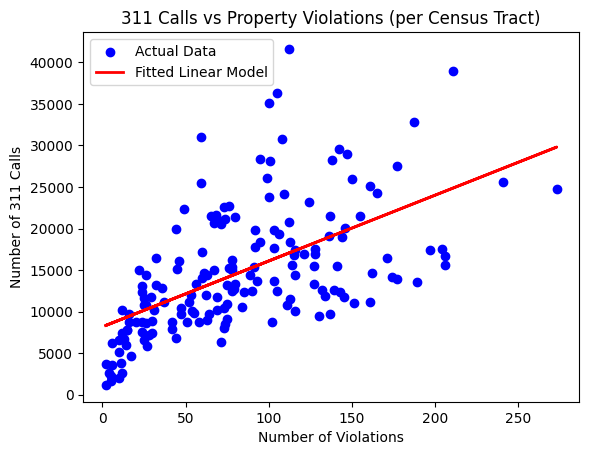

In [66]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import numpy as np

x = violations_311_cases["NUM_VIOLATIONS"].to_numpy().reshape(-1, 1)
y = violations_311_cases["NUM_CALLS"].to_numpy().reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

# Generate predictions using the fitted model
y_pred = model.predict(x)

# Create the scatterplot
plt.scatter(x, y, color='blue', label="Actual Data")

# Plot the linear model
plt.plot(x, y_pred, color='red', linewidth=2, label="Fitted Linear Model")

# Customize the plot
plt.title("311 Calls vs Property Violations (per Census Tract)")
plt.xlabel("Number of Violations")
plt.ylabel("Number of 311 Calls")
plt.legend()

# Show the plot
plt.show()

## 3. Choropleth

In [114]:
import folium
from folium.plugins import HeatMap
import json

boston_coordinates = [42.3601, -71.0589]
choropleth_311 = folium.Map(location=boston_coordinates, zoom_start=12)

# Load GeoJSON data for regions
regions_geojson = json.load(open('../data/Census_2010_Tracts.geojson', 'r'))

# Data to visualize on the choropleth map (a dictionary with region ID as key and value as the data)
data = {x["properties"]["GEOID10"][-6:] : cases_by_geoid[cases_by_geoid["CT_ID_10"] == int(x["properties"]["GEOID10"])]["NUM_CALLS"].values[0] for x in regions_geojson["features"]}

folium.Choropleth(
    geo_data=regions_geojson,
    data=data,
    columns=['TRACTCE10', 'value'],
    key_on='feature.properties.TRACTCE10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of 311 calls',
).add_to(choropleth_311)

choropleth_311.save('../output/choropleth_311.html')

In [33]:
import folium
from folium.plugins import HeatMap
import json

boston_coordinates = [42.3601, -71.0589]
choropleth_311 = folium.Map(location=boston_coordinates, zoom_start=12)

# Load GeoJSON data for regions
regions_geojson = json.load(open('../data/Census_2010_Tracts.geojson', 'r'))

# Data to visualize on the choropleth map (a dictionary with region ID as key and value as the data)
calls_svidx_df = pd.read_csv("../data/calls_svidx_df.csv")

data = {}
for region in regions_geojson["features"]:
    tractce10 = region["properties"]["GEOID10"][-6:]
    calls_per_pop = calls_svidx_df[calls_svidx_df["CT_ID_10"] == int(region["properties"]["GEOID10"])]["CALLS_PER_POP"]
    if len(calls_per_pop) == 1 and calls_per_pop.values[0] < 150:
        data[tractce10] = calls_per_pop.values[0]

bins = [0, 3, 5, 7, 10, 30, 70]

folium.Choropleth(
    geo_data=regions_geojson,
    data=data,
    columns=['TRACTCE10', 'value'],
    key_on='feature.properties.TRACTCE10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Number of 311 calls per capita',
).add_to(choropleth_311)

choropleth_311.save('../output/choropleth_311_per_capita.html')

- After seeing the map, it does not make sense to normalize 311 calls by capita as some of the census tracts have very small populations (residences), but are still popular for spending time (such as the Charles River).

In [50]:
import folium
from folium.plugins import HeatMap
import json

boston_coordinates = [42.3601, -71.0589]
choropleth_311 = folium.Map(location=boston_coordinates, zoom_start=12)

# Load GeoJSON data for regions
regions_geojson = json.load(open('../data/Census_2010_Tracts.geojson', 'r'))

# Data to visualize on the choropleth map (a dictionary with region ID as key and value as the data)
violations_by_geoid = violations.groupby(by=["GEOID10"]).size().reset_index(name="NUM_VIOLATIONS")

data = {}
for region in regions_geojson["features"]:
    tractce10 = region["properties"]["GEOID10"][-6:]
    violationss = violations_by_geoid[violations_by_geoid["GEOID10"] == int(region["properties"]["GEOID10"])]["NUM_VIOLATIONS"]
    if len(violationss) == 1:
        data[tractce10] = violationss.values[0]

bins = [0, 10, 25, 50, 100, 150, 200, 250, 300]

folium.Choropleth(
    geo_data=regions_geojson,
    data=data,
    columns=['TRACTCE10', 'value'],
    key_on='feature.properties.TRACTCE10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Number of Property Violations since 2009',
).add_to(choropleth_311)

choropleth_311.save('../output/choropleth_property_violations.html')